# Dimuon spectrum

This code is a columnar adaptation of [a ROOT tutorial](https://root.cern.ch/doc/master/df102__NanoAODDimuonAnalysis_8py.html) showcasing the awkward array toolset, and utilizing FCAT histograms.
This also shows the analysis object syntax implemented by FCAT `JaggedCandidateArray`, and the usage of an accumulator class provided by FCAT.

In [1]:
import time
import uproot
import awkward

from fnal_column_analysis_tools import hist
from fnal_column_analysis_tools.hist import plot
from fnal_column_analysis_tools.analysis_objects import JaggedCandidateArray
from fnal_column_analysis_tools.processor import defaultdict_accumulator

In [2]:
# uproot supports xrootd, but its nicer to have them local (about 7 GB)
!mkdir -p data
!xrdcp root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012B_DoubleMuParked.root data/
!xrdcp root://eospublic.cern.ch//eos/root-eos/cms_opendata_2012_nanoaod/Run2012C_DoubleMuParked.root data/

[0B/0B][100%][==================================================][0B/s]  
Run: [ERROR] Server responded with an error: [3006] File exists

[0B/0B][100%][==================================================][0B/s]  
Run: [ERROR] Server responded with an error: [3006] File exists



In [3]:
tstart = time.time()

files = [
    'data/Run2012B_DoubleMuParked.root',
    'data/Run2012C_DoubleMuParked.root',
]

masshist = hist.Hist("Counts", hist.Bin("mass", r"$m_{\mu\mu}$ [GeV]", 30000, 0.25, 300))
cutflow = defaultdict_accumulator(lambda: 0)

branches = ['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']
for chunk in uproot.iterate(files, 'Events', branches=branches, entrysteps=500000, namedecode='ascii'):
    muons = JaggedCandidateArray.candidatesfromcounts(chunk['nMuon'],
                                            pt=chunk['Muon_pt'].content,
                                            eta=chunk['Muon_eta'].content,
                                            phi=chunk['Muon_phi'].content,
                                            mass=chunk['Muon_mass'].content,
                                            charge=chunk['Muon_charge'].content,
                                           )
    
    cutflow['all events'] += muons.size
    twomuons = (muons.counts == 2)
    cutflow['two muons'] += twomuons.sum()
    opposite_charge = twomuons & (muons['charge'].prod() == -1)
    cutflow['opposite charge'] += opposite_charge.sum()
    dimuons = muons[opposite_charge].distincts()
    masshist.fill(mass=dimuons.mass.flatten())
    
elapsed = time.time() - tstart
print(dict(cutflow))

{'all events': 66128870, 'two muons': 33370298, 'opposite charge': 25794885}


(0.1, 1000000.0)

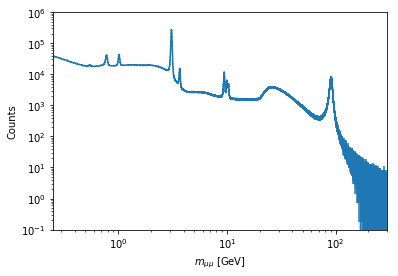

In [4]:
fig, ax, _ = plot.plot1d(masshist)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.1, 1e6)

In [5]:
print("Events/s:", cutflow['all events']/elapsed)

Events/s: 750231.3164802399
